In [11]:
from openbb import obb
import pandas as pd
import numpy as np
from scipy.stats import norm
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [12]:
def FetchRates(Start_Date=None, End_Date=None):
    treasury_data = obb.fixedincome.government.treasury_rates(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()
    fed_funds = obb.fixedincome.rate.effr(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()[['rate']].rename(columns={'rate': 'FedFunds'})
    sofr_data = obb.fixedincome.rate.sofr(start_date=Start_Date, end_date=End_Date, provider="federal_reserve").to_df()[['rate']].rename(columns={'rate': 'SOFR'})

    #Merge
    rates_data = treasury_data.join([fed_funds, sofr_data], how='outer')
    #Reset Index
    rates_data = rates_data.rename_axis('Date').reset_index()

    #Renaming Columns
    rates_data.rename(columns={
        "month_1": "1Mo", "month_2": "2Mo", "month_3": "3Mo", "month_6": "6Mo", 
        "year_1": "1Yr", "year_2": "2Yr", "year_3": "3Yr", 
        "year_5": "5Yr", "year_7": "7Yr", "year_10": "10Yr", "year_30": "30Yr"
    }, inplace=True)

    # Filter and Sort
    cols = ['Date', 'FedFunds', 'SOFR', '1Mo', '3Mo', '6Mo', '1Yr', '2Yr', '3Yr', '5Yr', '7Yr', '10Yr', '30Yr']
    rates_data = rates_data[cols].sort_values('Date')

    # Removing rows where primary benchmarks are missing (weekends/holidays)
    rates_data = rates_data.dropna(subset=['FedFunds', '1Mo'])
    
    # Forward Fill SOFR (Modern syntax)
    rates_data['SOFR'] = rates_data['SOFR'].ffill()
    
    return rates_data

In [13]:
# Filter for rows that contain any NaN values
#null_rows = rates_data[rates_data.isnull().any(axis=1)]
#null_rows

In [14]:
start_date = "2000-01-02"
end_date = dt.datetime.today().strftime('%Y-%m-%d')
rates_data=FetchRates(start_date, end_date)

<Axes: title={'center': '126-Day Rolling PCA: Explained Variance Over Time'}>

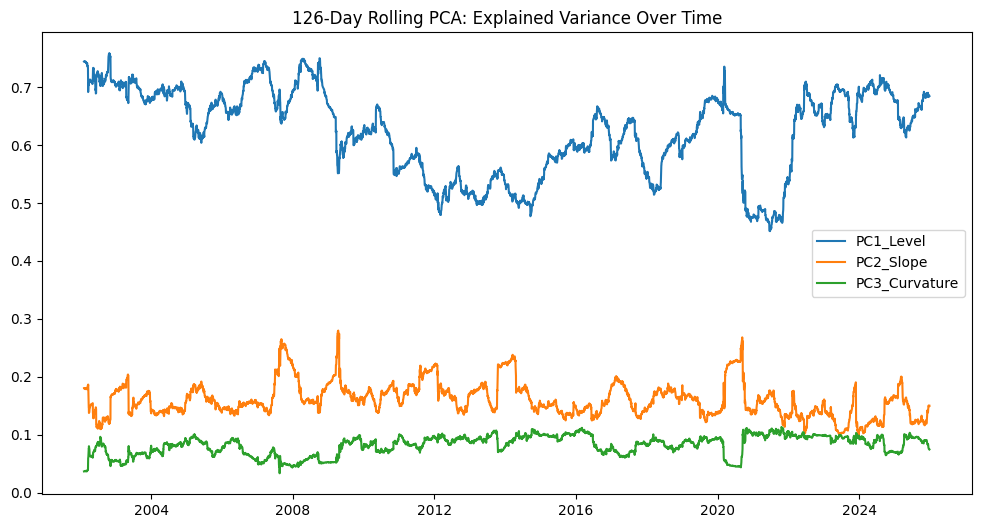

In [18]:
def calculate_rolling_pca(df, window): 
    tenors = ['1Mo', '3Mo', '6Mo', '1Yr', '2Yr', '3Yr', '5Yr', '7Yr', '10Yr', '30Yr']
    # We keep the index aligned with the original 'df' so we can look up the Date later
    diff_df = df[tenors].diff() 
    
    results = []
    dates = []
    
    # We start at 'window + 1' to account for the .diff() NaN at row 0
    for i in range(window + 1, len(df)):
        window_data = diff_df.iloc[i-window:i].dropna()
        
        scaler = StandardScaler()
        scaled_window = scaler.fit_transform(window_data)
        
        pca = PCA(n_components=3)
        pca.fit(scaled_window)
        
        results.append(pca.explained_variance_ratio_)
        # FIX: Capture the actual date from the 'Date' column instead of the integer index
        dates.append(df['Date'].iloc[i-1]) 
        
    rolling_var_df = pd.DataFrame(
        results, 
        columns=['PC1_Level', 'PC2_Slope', 'PC3_Curvature'], 
        index=dates
    )
    return rolling_var_df

rolling_window = 126
rolling_pca_results = calculate_rolling_pca(rates_data, rolling_window)

# Because 'index=dates', the x-axis will now automatically be the Date
rolling_pca_results.plot(figsize=(12,6), title=f'{rolling_window}-Day Rolling PCA: Explained Variance Over Time')